## real

In [69]:
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.util import ngrams
from scipy.special import rel_entr
from scipy.special import entr
from scipy.spatial import distance

from scipy.stats import energy_distance
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp




In [48]:
def ks_dist(real_obs, gen_obs):
    stat, pval = ks_2samp(real_obs, gen_obs)
    
    return stat

def comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth, real_cf, synth_cf):
    univariate_cont_res = {}

    for field in CONT_FIELDS:
        univariate_cont_res[field] = {}
        for name, fn in CONTINUOUS_METRICS.items():
            univariate_cont_res[field][name] = fn(real[field], synth[field])
            
    univariate_cont_res['CF'] = {}
    for name, fn in CONTINUOUS_METRICS.items():
        univariate_cont_res['CF'][name] = fn(real_cf[CF_FIELD], synth_cf[CF_FIELD])
    return univariate_cont_res

def comapre_unidist_cat(real, synth, field):
    real_distribution = real[field].value_counts(normalize=True).sort_index()
    synthetic_distribution = synth[field].value_counts(normalize=True).sort_index()
    df_tcode = pd.merge(real_distribution, synthetic_distribution, left_index=True, right_index=True, how='outer')
    df_tcode.columns = ['real', 'synthetic']

    # Fill missing values with 0
    df_tcode.fillna(0, inplace=True)
    df_tcode['mid'] = (df_tcode['real'] + df_tcode['synthetic'])/2
    kl_real_M = sum(rel_entr(df_tcode['real'], df_tcode['mid'])) 
    kl_gen_M = sum(rel_entr(df_tcode['synthetic'], df_tcode['mid']))

    jsd = (kl_real_M + kl_gen_M)/2
    return jsd

def create_ngramcount_df(df, n, field):
    #gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    gb = df.groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1
            
            
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)
    
            
    return df.reset_index().rename(columns={"index": "ngram"})

def compute_ngram_metrics(real_df, gen_df, field, n , pseudo_counts=0.0):

    
    n_codes_unique = len(set(real_df[field].unique()).union(set(gen_df[field].unique())))

    
    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    real_ngrams = create_ngramcount_df(real_df, n, field)
    gen_ngrams = create_ngramcount_df(gen_df, n, field)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)


    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    N_possible_ngrams = n_codes_unique**n 

    
    # add psudo-counts
    combo_df["counts_real"] += pseudo_counts
    combo_df["ps_real"] = combo_df["counts_real"] / (N_obs_real + N_possible_ngrams*pseudo_counts)
    combo_df["counts_gen"] += pseudo_counts
    combo_df["ps_gen"] = combo_df["counts_gen"] / (N_obs_gen + N_possible_ngrams*pseudo_counts)
    

        
        
    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2
        
        
    # compute entropy for both distributions
    n_unobs = N_possible_ngrams - len(combo_df)

    entr_r = entr(combo_df["ps_real"]).sum()  # from observed
    
    entr_g = entr(combo_df["ps_gen"]).sum()  # from observed
    
    results = {"jsd":jsd, 
                      "entr_r":entr_r, 
                      "entr_g":entr_g,
                      "NED": entr_r - entr_g,
                      "l1":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=1), 
                      "l2":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=2),
                      "jac": distance.jaccard(combo_df["counts_real"]>0, combo_df["counts_gen"] > 0),
                      "count_r": len(real_ngrams),
                      "coverage_r": len(real_ngrams)/N_possible_ngrams,
                      "count_g": len(gen_ngrams),
                      "coverage_g": len(gen_ngrams)/N_possible_ngrams,
                      "count_max": N_possible_ngrams,
                      "field": field, 
                       "n":n, 
                       "pseudo_counts":pseudo_counts}
        
    return combo_df, results

In [65]:
#joint distribution of two categorical columns
def compute_2d_categorical_metrics(real_df, gen_df, field1, field2):
    f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))
    f2_opts = set(real_df[field2].unique()).union(set(gen_df[field2].unique()))

    n_opts_total = len(f1_opts) * len(f2_opts)

    kl_r_m = 0.
    kl_g_m = 0.
    entr_r = 0.
    entr_g = 0.
    l1_d = 0.
    l2_d = 0.
    count_g = 0.
    count_r = 0.

    observed_opts = 0

    cont_metric_results = {}
    for code_1 in f1_opts:
        for code_2 in f2_opts:
            cond_r = np.logical_and(real_df[field1] == code_1, real_df[field2] == code_2)
            cond_g = np.logical_and(gen_df[field1] == code_1, gen_df[field2] == code_2)

            p_r = (np.sum(cond_r)) / (len(cond_r))    
            p_g = (np.sum(cond_g)) / (len(cond_g))    
            p_m = (p_r + p_g) / 2.

            if np.sum(cond_r) + np.sum(cond_g) > 0:
                observed_opts += 1


            count_r += int(np.sum(cond_r) > 0)
            count_g += int(np.sum(cond_g) > 0)

            l1_d += np.abs(p_r - p_g)
            l2_d += (p_r - p_g) ** 2 
                

            if p_r > 0:
                kl_r_m += p_r * np.log(p_r / p_m)
                entr_r += - p_r * np.log(p_r)

            if p_g > 0.:
                kl_g_m += p_g * np.log(p_g / p_m)
                entr_g += - p_g * np.log(p_g)

    # compute jaccard
    sr = set(zip(real_df[field1].to_list(), real_df[field2].to_list()))
    sg = set(zip(gen_df[field1].to_list(), gen_df[field2].to_list()))
    s_union = len(sr.union(sg))
    s_inter = len(sr.intersection(sg))
    jacc_d = (s_union - s_inter) / s_union

    # finshed l2
    l2_d = np.sqrt(l2_d)

    # coverage
    coverage_g = count_g / n_opts_total
    coverage_r = count_r / n_opts_total

    #jsd
    jsd = (kl_r_m + kl_g_m) / 2


    result = {'jsd': jsd,
                    'entr_r': entr_r,
                    'entr_g': entr_g,
                    'l1': l1_d,
                    'l2': l2_d,
                    'jac': jacc_d,
                    'count_r': count_r,
                    'coverage_r': coverage_r,
                    'count_g': count_g,
                    'coverage_g': coverage_g,
                    'count_max': n_opts_total}
    return result


In [20]:
#dataset is downloaded from https://github.com/BigTuna08/Banksformer_ecml_2022/tree/4e998944825f04f94f6cb3a0058b4733fd70ccf5/czech/banksformer/data
real = pd.read_csv('../CTGAN/tr_by_acct_w_age.csv')
real

,Unnamed: 0,column_a,account_id,date,type,operation,amount,balance,k_symbol,age,tcode
0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,29,cash_cr
1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,29,bank_cr
2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,29,cash_cr
3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,29,interest_cr
4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,29,bank_cr
...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056315,1033141,11382,981202,DEBIT,CASH WITHDRAWAL,25600.0,41114.4,NaN,46,cash_db_nan
1056316,1056316,1040574,11382,981210,CREDIT,COLLECTION FROM ANOTHER BANK,46248.0,87362.4,NaN,46,bank_cr
1056317,1056317,1050362,11382,981225,DEBIT,CASH WITHDRAWAL,6300.0,81062.4,NaN,46,cash_db_nan
1056318,1056318,1053037,11382,981231,CREDIT,NaN,311.3,81373.6,INTEREST CREDITED,46,interest_cr


In [21]:
# data preprocessing , some parts are the same as 
#https://github.com/BigTuna08/Banksformer_ecml_2022/blob/4e998944825f04f94f6cb3a0058b4733fd70ccf5/czech/banksformer/nb1_preprocess_czech.ipynb

real = real.sort_values(by = ["account_id", "date"])
czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
real["datetime"] = real["date"].apply(czech_date_parser)
#df["datetime"] = pd.to_datetime(df["datetime"])

real["month"] = real["datetime"].dt.month
real["day"] = real["datetime"].dt.day
real["dow"] =  real["datetime"].dt.dayofweek
real["year"] = real["datetime"].dt.year
real["doy"] = real["datetime"].dt.dayofyear


real["td"] = real[["account_id", "datetime"]].groupby("account_id").diff()
real["td"] = real["td"].apply(lambda x: x.days)
real["td"].fillna(0.0, inplace=True)


real['raw_amount'] = real.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)


bin_edges = [17, 30, 40, 50, 60, 81]
labels = ['18-30', '31-40', '41-50', '51-60', '61+']
# Use pd.cut() to convert ages to categorical groups
real['age_group'] = pd.cut(real['age'], bins=bin_edges, labels=labels, right=False)
real['age_group'] = real['age_group'].astype('object')


conditions = [
    (real['day'] >= 1) & (real['day'] <= 10),
    (real['day'] > 10) & (real['day'] <= 20),
    (real['day'] > 20) & (real['day'] <= 31)
      ]
categories = ['first', 'middle', 'last']
real['dtme_cat'] = np.select(conditions, categories)


cat_code_fields = ['type', 'operation', 'k_symbol']
TCODE_SEP = "__"
# create tcode by concating fields in "cat_code_fields"
tcode = real[cat_code_fields[0]].astype(str)
for ccf in cat_code_fields[1:]:
    tcode += TCODE_SEP + real[ccf].astype(str)

real["tcode"] = tcode


In [5]:
real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])

In [6]:
real

,Unnamed: 0,column_a,account_id,date,type,operation,amount,balance,k_symbol,age,...,datetime,month,day,dow,year,doy,td,raw_amount,age_group,dtme_cat
0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,29,...,1995-03-24,3,24,4,1995,83,0.0,1000.0,18-30,last
1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,29,...,1995-04-13,4,13,3,1995,103,20.0,3679.0,18-30,middle
2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,29,...,1995-04-23,4,23,6,1995,113,10.0,12600.0,18-30,last
3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,29,...,1995-04-30,4,30,6,1995,120,7.0,19.2,18-30,last
4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,29,...,1995-05-13,5,13,5,1995,133,13.0,3679.0,18-30,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056315,1033141,11382,981202,DEBIT,CASH WITHDRAWAL,25600.0,41114.4,NaN,46,...,1998-12-02,12,2,2,1998,336,2.0,-25600.0,41-50,first
1056316,1056316,1040574,11382,981210,CREDIT,COLLECTION FROM ANOTHER BANK,46248.0,87362.4,NaN,46,...,1998-12-10,12,10,3,1998,344,8.0,46248.0,41-50,first
1056317,1056317,1050362,11382,981225,DEBIT,CASH WITHDRAWAL,6300.0,81062.4,NaN,46,...,1998-12-25,12,25,4,1998,359,15.0,-6300.0,41-50,last
1056318,1056318,1053037,11382,981231,CREDIT,NaN,311.3,81373.6,INTEREST CREDITED,46,...,1998-12-31,12,31,3,1998,365,6.0,311.3,41-50,last


In [7]:
real[['amount', 'tcode', 'month', 'dow', 'year', 'dtme_cat', 'age_group', 'td']]   #real data given to discriminator


,amount,tcode,month,dow,year,dtme_cat,age_group,td
0,1000.0,CREDIT__CREDIT IN CASH__nan,3,4,1995,last,18-30,0.0
1,3679.0,CREDIT__COLLECTION FROM ANOTHER BANK__nan,4,3,1995,middle,18-30,20.0
2,12600.0,CREDIT__CREDIT IN CASH__nan,4,6,1995,last,18-30,10.0
3,19.2,CREDIT__nan__INTEREST CREDITED,4,6,1995,last,18-30,7.0
4,3679.0,CREDIT__COLLECTION FROM ANOTHER BANK__nan,5,5,1995,middle,18-30,13.0
...,...,...,...,...,...,...,...,...
1056315,25600.0,DEBIT__CASH WITHDRAWAL__nan,12,2,1998,first,41-50,2.0
1056316,46248.0,CREDIT__COLLECTION FROM ANOTHER BANK__nan,12,3,1998,first,41-50,8.0
1056317,6300.0,DEBIT__CASH WITHDRAWAL__nan,12,4,1998,last,41-50,15.0
1056318,311.3,CREDIT__nan__INTEREST CREDITED,12,3,1998,last,41-50,6.0


In [8]:
real['tcode'].unique()

array(['CREDIT__CREDIT IN CASH__nan',
       'CREDIT__COLLECTION FROM ANOTHER BANK__nan',
       'CREDIT__nan__INTEREST CREDITED', 'DEBIT__CASH WITHDRAWAL__nan',
       'DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT',
       'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',
       'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT',
       'DEBIT__REMITTANCE TO ANOTHER BANK__ ',
       'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT',
       'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION',
       'DEBIT__CREDIT CARD WITHDRAWAL__nan',
       'DEBIT__REMITTANCE TO ANOTHER BANK__nan',
       'DEBIT__CASH WITHDRAWAL__HOUSEHOLD',
       'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',
       'DEBIT__CASH WITHDRAWAL__ ',
       'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT'], dtype=object)

In [9]:
import numpy as np
conditions = [
(real['day'] >= 1) & (real['day'] <= 10),
(real['day'] > 10) & (real['day'] <= 20),
(real['day'] > 20) & (real['day'] <= 31)
    ]
    
categories = ['first', 'middle', 'last']

# Use numpy.select() to map the numbers to categories
real['dtme_cat'] = np.select(conditions, categories)

In [10]:
cat_order = ['first', 'middle', 'last']
real['dtme_cat_order'] = pd.Categorical(real['dtme_cat'], categories=cat_order, ordered=True)

# Sort the DataFrame based on 'account_id', 'year', 'month', 'dow', and 'dtme_cat'
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])

## synth

In [29]:
synth = pd.read_csv('synth.csv')
synth

,amount,tcode,month,dow,year,dtme_cat,age_group,td
0,6000.984844,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE P...,3,2,1997,first,51-60,1.173169
1,-788.373432,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,11,6,1996,last,31-40,4.108638
2,21545.802611,CREDIT__CREDIT IN CASH__nan,1,6,1997,first,31-40,0.918106
3,5787.214126,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE P...,2,2,1997,first,51-60,5.593859
4,2515.699736,DEBIT__CASH WITHDRAWAL__nan,3,1,1997,first,31-40,6.379620
...,...,...,...,...,...,...,...,...
3995,55.376225,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,0,1998,last,61+,0.017258
3996,1252.254299,DEBIT__CASH WITHDRAWAL__nan,10,4,1996,middle,51-60,1.180114
3997,11908.408018,CREDIT__CREDIT IN CASH__nan,4,6,1998,middle,51-60,2.961073
3998,436.063440,DEBIT__CASH WITHDRAWAL__nan,1,1,1995,first,31-40,4.842274


In [30]:
conditions = [
    (synth['dtme_cat'] == 'first'),
    (synth['dtme_cat'] == 'middle'),
    (synth['dtme_cat'] == 'last')
]

# Create the 'day' column based on 'dtme_cat'
synth['day'] = np.select(conditions, [
    np.random.randint(1, 11, size=len(synth)),   # Random values between 1 and 10
    np.random.randint(10, 21, size=len(synth)),  # Random values between 10 and 20
    np.random.randint(20, 31, size=len(synth))   # Random values between 20 and 30
])


In [31]:
synth

,amount,tcode,month,dow,year,dtme_cat,age_group,td,day
0,6000.984844,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE P...,3,2,1997,first,51-60,1.173169,7
1,-788.373432,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,11,6,1996,last,31-40,4.108638,30
2,21545.802611,CREDIT__CREDIT IN CASH__nan,1,6,1997,first,31-40,0.918106,4
3,5787.214126,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE P...,2,2,1997,first,51-60,5.593859,3
4,2515.699736,DEBIT__CASH WITHDRAWAL__nan,3,1,1997,first,31-40,6.379620,1
...,...,...,...,...,...,...,...,...,...
3995,55.376225,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,0,1998,last,61+,0.017258,29
3996,1252.254299,DEBIT__CASH WITHDRAWAL__nan,10,4,1996,middle,51-60,1.180114,11
3997,11908.408018,CREDIT__CREDIT IN CASH__nan,4,6,1998,middle,51-60,2.961073,13
3998,436.063440,DEBIT__CASH WITHDRAWAL__nan,1,1,1995,first,31-40,4.842274,2


In [32]:
synth['account_id'] = (synth.index // 80) + 1

In [33]:
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

In [34]:
cat_order = ['first', 'middle', 'last']
synth['dtme_cat_order'] = pd.Categorical(synth['dtme_cat'], categories=cat_order, ordered=True)

# Sort the DataFrame based on 'account_id', 'year', 'month', 'dow', and 'dtme_cat'
synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

# Calculate the sum of 'raw_amount' for each 'account_id' in each 'month'
synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [35]:
synth_sorted

,amount,tcode,month,dow,year,dtme_cat,age_group,td,day,account_id,type,raw_amount,dtme_cat_order
56,1320.637478,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4,3,1993,middle,61+,2.810049,10,1,DEBIT,-1320.637478,middle
45,-874.737235,DEBIT__CASH WITHDRAWAL__nan,1,0,1995,middle,51-60,3.768954,14,1,DEBIT,874.737235,middle
32,142.130913,DEBIT__CASH WITHDRAWAL__nan,1,1,1995,last,51-60,15.043193,26,1,DEBIT,-142.130913,last
5,151.876689,CREDIT__nan__INTEREST CREDITED,6,3,1995,last,31-40,2.170649,29,1,CREDIT,151.876689,last
44,-125.579254,DEBIT__CASH WITHDRAWAL__nan,7,2,1995,last,31-40,3.282290,29,1,DEBIT,125.579254,last
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,55.376225,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,0,1998,last,61+,0.017258,29,50,CREDIT,55.376225,last
3960,2970.501907,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,10,3,1998,middle,31-40,3.956926,17,50,DEBIT,-2970.501907,middle
3988,181.378304,CREDIT__nan__INTEREST CREDITED,10,2,1998,last,51-60,0.026866,30,50,CREDIT,181.378304,last
3982,2699.952496,CREDIT__nan__INTEREST CREDITED,11,0,1998,last,18-30,5.350949,21,50,CREDIT,2699.952496,last


In [46]:
# the column names of continous features
CONT_FIELDS = ["amount", "td"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 1626.505185236183,
  'ks': 0.17368312632535596,
  'energy_d': 12.757106607028666},
 'td': {'wasser': 1.0189492696349403,
  'ks': 0.12718320205998185,
  'energy_d': 0.319319711501024},
 'CF': {'wasser': 2542.3328818878304,
  'ks': 0.25618140634954634,
  'energy_d': 19.675372821093546}}

In [37]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.21533645818757616,
 'entr_r': 5.425261658301508,
 'entr_g': 5.411198269938771,
 'NED': 0.014063388362737683,
 'l1': 1.0011353422704299,
 'l2': 0.084463061277614,
 'jac': 0.737620578778135,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 532,
 'coverage_g': 0.1298828125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [50]:
# JSD result comparing the univariate distributions of the tcode (Tcode), dtme_cat, and DOM
CAT_FIELDS = ['tcode', 'dtme_cat', 'day']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat


{'tcode': 0.011530278901628317,
 'dtme_cat': 0.0002999375208018228,
 'day': 0.14261744474579}

## synth_bf

In [22]:
synth_bf = pd.read_csv('banksformer.csv')
synth_bf

,amount,tcode_num,days_passed,age,date,tcode,account_id,i,fname,old_account_id,select_by_col,n_datasets
0,4830.29,0,1,32,1994-04-28,CREDIT__CREDIT IN CASH__nan,24000000001,1,sqrt-log_var__gen_vthesis__scriptid_24-nld_4-d...,24,clf_cols_meanrank,23
1,18.52,4,2,32,1994-04-30,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,24000000001,1,sqrt-log_var__gen_vthesis__scriptid_24-nld_4-d...,24,clf_cols_meanrank,23
2,188.70,2,0,32,1994-04-30,CREDIT__nan__INTEREST CREDITED,24000000001,1,sqrt-log_var__gen_vthesis__scriptid_24-nld_4-d...,24,clf_cols_meanrank,23
3,4232.46,5,6,32,1994-05-06,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,24000000001,1,sqrt-log_var__gen_vthesis__scriptid_24-nld_4-d...,24,clf_cols_meanrank,23
4,1612.64,7,4,32,1994-05-10,DEBIT__REMITTANCE TO ANOTHER BANK__,24000000001,1,sqrt-log_var__gen_vthesis__scriptid_24-nld_4-d...,24,clf_cols_meanrank,23
...,...,...,...,...,...,...,...,...,...,...,...,...
183435,5410.92,0,6,23,1996-02-06,CREDIT__CREDIT IN CASH__nan,104800000000028,28,sqrt-log_var__gen_vthesis__scriptid_12-nld_4-d...,10480,clf_cols_meanrank,23
183436,2466.48,5,8,23,1996-02-14,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,104800000000028,28,sqrt-log_var__gen_vthesis__scriptid_12-nld_4-d...,10480,clf_cols_meanrank,23
183437,2116.18,3,12,23,1996-02-26,DEBIT__CASH WITHDRAWAL__nan,104800000000028,28,sqrt-log_var__gen_vthesis__scriptid_12-nld_4-d...,10480,clf_cols_meanrank,23
183438,64.37,2,3,23,1996-02-29,CREDIT__nan__INTEREST CREDITED,104800000000028,28,sqrt-log_var__gen_vthesis__scriptid_12-nld_4-d...,10480,clf_cols_meanrank,23


In [23]:
synth_bf = pd.read_csv('banksformer.csv')
synth_bf = synth_bf[['amount', 'date', 'tcode', 'old_account_id','days_passed']]
synth_bf = synth_bf.rename(columns={'old_account_id': 'account_id', 'days_passed': 'td'})
synth_bf

,amount,date,tcode,account_id,td
0,4830.29,1994-04-28,CREDIT__CREDIT IN CASH__nan,24,1
1,18.52,1994-04-30,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,24,2
2,188.70,1994-04-30,CREDIT__nan__INTEREST CREDITED,24,0
3,4232.46,1994-05-06,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,24,6
4,1612.64,1994-05-10,DEBIT__REMITTANCE TO ANOTHER BANK__,24,4
...,...,...,...,...,...
183435,5410.92,1996-02-06,CREDIT__CREDIT IN CASH__nan,10480,6
183436,2466.48,1996-02-14,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,10480,8
183437,2116.18,1996-02-26,DEBIT__CASH WITHDRAWAL__nan,10480,12
183438,64.37,1996-02-29,CREDIT__nan__INTEREST CREDITED,10480,3


In [24]:
# Convert the 'date' column to datetime type
synth_bf['date'] = pd.to_datetime(synth_bf['date'])

# Extract year, month, and day into separate columns
synth_bf['year'] = synth_bf['date'].dt.year
synth_bf['month'] = synth_bf['date'].dt.month
synth_bf['day'] = synth_bf['date'].dt.day

In [25]:
synth_bf['type'] = synth_bf['tcode'].str.split('__').str[0]
synth_bf['raw_amount'] = synth_bf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

In [26]:
synthbf_sorted = synth_bf.sort_values(['account_id', 'year', 'month', 'day'])
synthbf_cf = synth_bf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [51]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth_bf, real_cf, synthbf_cf)

{'amount': {'wasser': 2448.161642487449,
  'ks': 0.10720187285817662,
  'energy_d': 18.59067511299106},
 'td': {'wasser': 0.6694753989130681,
  'ks': 0.048665168961869565,
  'energy_d': 0.20715855217029622},
 'CF': {'wasser': 1836.7479341522258,
  'ks': 0.07386091403941353,
  'energy_d': 9.771341350661983}}

In [39]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synthbf_sorted, 'tcode', 3)
result

{'jsd': 0.015564346511028806,
 'entr_r': 5.425261658301508,
 'entr_g': 5.469925106657435,
 'NED': -0.044663448355926505,
 'l1': 0.21457844271704535,
 'l2': 0.017261164915751803,
 'jac': 0.3930731170973062,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1492,
 'coverage_g': 0.3642578125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [52]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_bf, field)
result_jst_cat

{'tcode': 0.0010911052812377416, 'day': 0.0030761017089523377}

## synth2

In [51]:
import pandas as pd
synth2 = pd.read_csv('synth2.csv')
synth2[synth2['account_id'] == 2]

,amount,tcode,td,account_id,cumulative_td,datetime
13,11127.105000,CREDIT__CREDIT IN CASH__nan,2.239054,2,2.239054,1993-12-12
14,15559.107235,CREDIT__CREDIT IN CASH__nan,-0.136424,2,2.102630,1993-12-12
15,328.718276,CREDIT__nan__INTEREST CREDITED,0.012552,2,2.115182,1993-12-12
16,8988.638536,CREDIT__CREDIT IN CASH__nan,7.305095,2,9.420277,1993-12-19
17,23382.145011,CREDIT__CREDIT IN CASH__nan,7.631188,2,17.051465,1993-12-27
...,...,...,...,...,...,...
318,-5.629679,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1.612772,2,1382.207612,1997-09-22
319,12430.407972,CREDIT__CREDIT IN CASH__nan,2.428415,2,1384.636027,1997-09-24
320,5253.606435,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,0.627236,2,1385.263263,1997-09-25
321,1402.913802,DEBIT__CASH WITHDRAWAL__nan,7.778869,2,1393.042132,1997-10-03


In [52]:
# Convert the 'date' column to datetime type
synth2['date'] = pd.to_datetime(synth2['datetime'])

# Extract year, month, and day into separate columns
synth2['year'] = synth2['date'].dt.year
synth2['month'] = synth2['date'].dt.month
synth2['day'] = synth2['date'].dt.day

synth2['type'] = synth2['tcode'].str.split('__').str[0]
synth2['raw_amount'] = synth2.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth2_sorted = synth2.sort_values(['account_id', 'year', 'month', 'day'])

synth2_cf = synth2[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [53]:
synth2_sorted

,amount,tcode,td,account_id,cumulative_td,datetime,date,year,month,day,type,raw_amount
0,12975.673512,CREDIT__CREDIT IN CASH__nan,0.008127,1,0.008127,1997-12-15,1997-12-15,1997,12,15,CREDIT,12975.673512
1,12723.168054,CREDIT__CREDIT IN CASH__nan,6.326939,1,6.335065,1997-12-21,1997-12-21,1997,12,21,CREDIT,12723.168054
2,7755.251967,CREDIT__CREDIT IN CASH__nan,13.161087,1,19.496153,1998-01-03,1998-01-03,1998,1,3,CREDIT,7755.251967
3,14645.096592,CREDIT__CREDIT IN CASH__nan,12.126284,1,31.622437,1998-01-15,1998-01-15,1998,1,15,CREDIT,14645.096592
4,9108.556896,CREDIT__CREDIT IN CASH__nan,9.991226,1,41.613662,1998-01-25,1998-01-25,1998,1,25,CREDIT,9108.556896
...,...,...,...,...,...,...,...,...,...,...,...,...
7545,16095.739371,DEBIT__REMITTANCE TO ANOTHER BANK__nan,0.020320,30,851.085977,1998-04-18,1998-04-18,1998,4,18,DEBIT,-16095.739371
7546,13602.556009,DEBIT__CASH WITHDRAWAL__nan,0.030395,30,851.116372,1998-04-18,1998-04-18,1998,4,18,DEBIT,-13602.556009
7547,1417.180309,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1.528316,30,852.644688,1998-04-19,1998-04-19,1998,4,19,CREDIT,1417.180309
7548,1175.677607,DEBIT__CASH WITHDRAWAL__nan,10.370776,30,863.015464,1998-04-30,1998-04-30,1998,4,30,DEBIT,-1175.677607


In [54]:
from scipy.stats import energy_distance
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

def ks_dist(real_obs, gen_obs):
    stat, pval = ks_2samp(real_obs, gen_obs)
    
    return stat

# the column names of continous features
CONT_FIELDS = ["amount"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
univariate_cont_res = {}

for field in CONT_FIELDS:
    univariate_cont_res[field] = {}
    for name, fn in CONTINUOUS_METRICS.items():
        univariate_cont_res[field][name] = fn(real[field], synth2[field])

In [55]:
univariate_cont_res

{'amount': {'wasser': 1675.147407619936,
  'ks': 0.127324555222078,
  'energy_d': 12.179646154520485}}

In [56]:
# Calculate the sum of 'raw_amount' for each 'account_id' in each 'month'
real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth2_cf = synth2[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [57]:
real_cf

,account_id,month,year,raw_amount
0,1,1,1996,-4593.5
1,1,1,1997,157.8
2,1,1,1998,-1621.7
3,1,2,1996,1372.1
4,1,2,1997,1770.7
...,...,...,...,...
185052,11382,11,1998,12336.5
185053,11382,12,1995,10563.6
185054,11382,12,1996,-5313.8
185055,11382,12,1997,17677.7


In [58]:
field = 'raw_amount'
univariate_cont_res['CF'] = {}
for name, fn in CONTINUOUS_METRICS.items():
    univariate_cont_res['CF'][name] = fn(real_cf[field], synth_cf2[field])

In [59]:
univariate_cont_res

{'amount': {'wasser': 1675.147407619936,
  'ks': 0.127324555222078,
  'energy_d': 12.179646154520485},
 'CF': {'wasser': 9501.523418206052,
  'ks': 0.28641255747498695,
  'energy_d': 56.20073869688241}}

In [60]:
# Sort the DataFrame based on 'account_id', 'year', 'month', 'dow', and 'dtme_cat'
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth2_sorted, 'tcode', 3)
result['jsd']

0.09467495924757047

In [61]:
#JSD results comparing the univariate distributions of the tcode (Tcode)
real_distribution = real['tcode'].value_counts(normalize=True).sort_index()
synthetic_distribution = synth2['tcode'].value_counts(normalize=True).sort_index()
df_tcode = pd.merge(real_distribution, synthetic_distribution, left_index=True, right_index=True, how='outer')
df_tcode.columns = ['real', 'synthetic']

# Fill missing values with 0
df_tcode.fillna(0, inplace=True)
df_tcode['mid'] = (df_tcode['real'] + df_tcode['synthetic'])/2
kl_real_M = sum(rel_entr(df_tcode['real'], df_tcode['mid'])) 
kl_gen_M = sum(rel_entr(df_tcode['synthetic'], df_tcode['mid']))

jsd = (kl_real_M + kl_gen_M)/2
jsd

0.004887786848359842

In [62]:
#JSD results comparing the univariate distributions of the transaction day of the month (DoM)
real_distribution2 = real['day'].value_counts(normalize=True).sort_index()
synthetic_distribution2 = synth2['day'].value_counts(normalize=True).sort_index()
df_dom = pd.merge(real_distribution2, synthetic_distribution2, left_index=True, right_index=True, how='outer')
df_dom.columns = ['real', 'synthetic']
# Fill missing values with 0
df_dom.fillna(0, inplace=True)
df_dom['mid'] = (df_dom['real'] + df_dom['synthetic'])/2
kl_real_M = sum(rel_entr(df_dom['real'], df_dom['mid'])) 
kl_gen_M = sum(rel_entr(df_dom['synthetic'], df_dom['mid']))

jsd = (kl_real_M + kl_gen_M)/2
jsd


0.10809539040944727

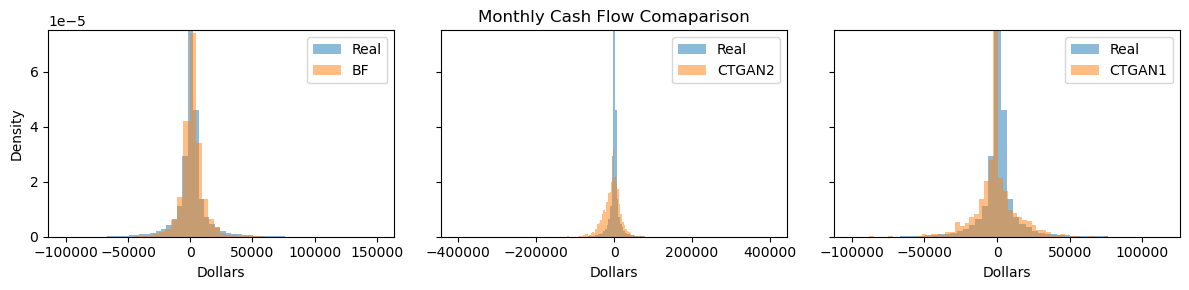

In [65]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(12,3), sharey=True)


for i, (vals, lbl) in enumerate([(synthbf_cf, "BF"), (synth2_cf, "CTGAN2"), (synth_cf, "CTGAN1")]):
    
    
    ax[i].hist(real_cf.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[i].set_ylim([0.0, 0.000075])
    
    if i==1:
        ax[i].set_xlim([-10e5/2.25, 10e5/2.25])
        
    ax[i].legend()
    
    wd = wasserstein_distance(real_cf.raw_amount, vals.raw_amount)
    # print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")

ax[0].set_ylabel("Density")

ax[0].set_xlabel("Dollars")
ax[1].set_xlabel("Dollars")
ax[2].set_xlabel("Dollars")
    

plt.tight_layout()
plt.show()

## synth_ctgan

In [53]:
synth_ctgan = pd.read_csv('../CTGAN/synth.csv')
synth_ctgan

,amount,tcode,td,account_id,cumulative_td,datetime
0,5145.529465,CREDIT__CREDIT IN CASH__nan,8,1,8,1994-12-20
1,4372.565193,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,1,1,9,1994-12-21
2,5152.950915,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,4,1,13,1994-12-25
3,5273.613582,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,1,21,1995-01-02
4,6167.951270,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,3,1,24,1995-01-05
...,...,...,...,...,...,...
187590,42672.918094,DEBIT__CASH WITHDRAWAL__nan,0,800,1860,2003-01-10
187591,12528.841814,DEBIT__CASH WITHDRAWAL__nan,9,800,1869,2003-01-19
187592,4256.349425,CREDIT__CREDIT IN CASH__nan,1,800,1870,2003-01-20
187593,1952.471286,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4,800,1874,2003-01-24


In [54]:
# Convert the 'date' column to datetime type
synth_ctgan['date'] = pd.to_datetime(synth_ctgan['datetime'])

# Extract year, month, and day into separate columns
synth_ctgan['year'] = synth_ctgan['date'].dt.year
synth_ctgan['month'] = synth_ctgan['date'].dt.month
synth_ctgan['day'] = synth_ctgan['date'].dt.day

synth_ctgan['type'] = synth_ctgan['tcode'].str.split('__').str[0]
synth_ctgan['raw_amount'] = synth_ctgan.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_ctgan_sorted = synth_ctgan.sort_values(['account_id', 'year', 'month', 'day'])

synth_ctgan_cf = synth_ctgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [55]:
CONT_FIELDS = ["amount", "td"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth_ctgan, real_cf, synth_ctgan_cf)

{'amount': {'wasser': 232.14402701283635,
  'ks': 0.07302801887859399,
  'energy_d': 1.8504735150632847},
 'td': {'wasser': 0.5019526493277742,
  'ks': 0.049752280464276044,
  'energy_d': 0.1633527951839794},
 'CF': {'wasser': 11765.836226459372,
  'ks': 0.21731870335639317,
  'energy_d': 54.60111643510508}}

In [56]:
combo_df, result = compute_ngram_metrics(real_sorted, synth_ctgan_sorted, 'tcode', 3)
result

{'jsd': 0.008625092398845395,
 'entr_r': 5.425261658301508,
 'entr_g': 5.435552196183742,
 'NED': -0.01029053788223333,
 'l1': 0.14221318603453398,
 'l2': 0.008856719785441104,
 'jac': 0.22835195530726257,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1106,
 'coverage_g': 0.27001953125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [57]:
#JSD results comparing the univariate distributions of the tcode (Tcode) and DOM
CAT_FIELDS = ['tcode', 'day']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_ctgan, field)
result_jst_cat

{'tcode': 0.000507487708211092, 'day': 0.10872697936183681}

## Synth3_SeqCTGAN

In [58]:
synth3 = pd.read_csv('synth3.csv')
synth3

,amount,tcode,td,account_id,cumulative_td,datetime
0,20911.988550,CREDIT__CREDIT IN CASH__nan,9,1,9,1997-10-09
1,974.313233,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,2,1,11,1997-10-11
2,588.828748,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,1,19,1997-10-19
3,1203.381066,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,1,27,1997-10-27
4,3009.043445,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,7,1,34,1997-11-03
...,...,...,...,...,...,...
189170,2105.639105,DEBIT__CASH WITHDRAWAL__nan,15,800,494,1996-05-15
189171,3934.599581,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,5,800,499,1996-05-20
189172,-202.667504,DEBIT__REMITTANCE TO ANOTHER BANK__,2,800,501,1996-05-22
189173,1056.105628,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1,800,502,1996-05-23


In [59]:
# Convert the 'date' column to datetime type
synth3['date'] = pd.to_datetime(synth3['datetime'])

# Extract year, month, and day into separate columns
synth3['year'] = synth3['date'].dt.year
synth3['month'] = synth3['date'].dt.month
synth3['day'] = synth3['date'].dt.day

synth3['type'] = synth3['tcode'].str.split('__').str[0]
synth3['raw_amount'] = synth3.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth3_sorted = synth3.sort_values(['account_id', 'year', 'month', 'day'])

synth3_cf = synth3[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [60]:
synth3

,amount,tcode,td,account_id,cumulative_td,datetime,date,year,month,day,type,raw_amount
0,20911.988550,CREDIT__CREDIT IN CASH__nan,9,1,9,1997-10-09,1997-10-09,1997,10,9,CREDIT,20911.988550
1,974.313233,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,2,1,11,1997-10-11,1997-10-11,1997,10,11,CREDIT,974.313233
2,588.828748,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,1,19,1997-10-19,1997-10-19,1997,10,19,CREDIT,588.828748
3,1203.381066,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,8,1,27,1997-10-27,1997-10-27,1997,10,27,CREDIT,1203.381066
4,3009.043445,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,7,1,34,1997-11-03,1997-11-03,1997,11,3,CREDIT,3009.043445
...,...,...,...,...,...,...,...,...,...,...,...,...
189170,2105.639105,DEBIT__CASH WITHDRAWAL__nan,15,800,494,1996-05-15,1996-05-15,1996,5,15,DEBIT,-2105.639105
189171,3934.599581,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,5,800,499,1996-05-20,1996-05-20,1996,5,20,DEBIT,-3934.599581
189172,-202.667504,DEBIT__REMITTANCE TO ANOTHER BANK__,2,800,501,1996-05-22,1996-05-22,1996,5,22,DEBIT,202.667504
189173,1056.105628,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1,800,502,1996-05-23,1996-05-23,1996,5,23,CREDIT,1056.105628


In [62]:
CONT_FIELDS = ["amount", "td"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth3, real_cf, synth3_cf)

{'amount': {'wasser': 968.367664679478,
  'ks': 0.19884856555796193,
  'energy_d': 8.03197214581269},
 'td': {'wasser': 1.0584788009053887,
  'ks': 0.09720315226889409,
  'energy_d': 0.35983150679824827},
 'CF': {'wasser': 11542.220583123368,
  'ks': 0.3172027472647091,
  'energy_d': 62.70560550960146}}

In [63]:
combo_df, result = compute_ngram_metrics(real_sorted, synth3_sorted, 'tcode', 3)
result

{'jsd': 0.005846674724639265,
 'entr_r': 5.425261658301508,
 'entr_g': 5.384531190430438,
 'NED': 0.04073046787107071,
 'l1': 0.1154494327999236,
 'l2': 0.00690031586342402,
 'jac': 0.25488826815642457,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1068,
 'coverage_g': 0.2607421875,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [64]:
#JSD results comparing the univariate distributions of the tcode (Tcode) and DOM
CAT_FIELDS = ['tcode', 'day']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth3, field)
result_jst_cat

{'tcode': 0.0004979798929764703, 'day': 0.10904014923287056}

## synth_prun

In [70]:
synth_prun = pd.read_csv('../CTGAN-PRUN/synth.csv')
synth_prun

,amount,tcode,td,account_id,cumulative_td,datetime
0,1256.157437,CREDIT__CREDIT IN CASH__nan,1,1,1,1998-04-14
1,8.935279,CREDIT__CREDIT IN CASH__nan,7,1,8,1998-04-21
2,11831.912441,CREDIT__CREDIT IN CASH__nan,16,1,24,1998-05-07
3,102.198887,CREDIT__nan__INTEREST CREDITED,24,1,48,1998-05-31
4,18181.916070,CREDIT__CREDIT IN CASH__nan,2,1,50,1998-06-02
...,...,...,...,...,...,...
192659,4223.295810,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE ...,30,800,748,1999-01-18
192660,3583.614102,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,5,800,753,1999-01-23
192661,4593.673248,DEBIT__CASH WITHDRAWAL__nan,3,800,756,1999-01-26
192662,683.274488,DEBIT__CASH WITHDRAWAL__nan,9,800,765,1999-02-04


In [71]:
# Convert the 'date' column to datetime type
synth_prun['date'] = pd.to_datetime(synth_prun['datetime'])

# Extract year, month, and day into separate columns
synth_prun['year'] = synth_prun['date'].dt.year
synth_prun['month'] = synth_prun['date'].dt.month
synth_prun['day'] = synth_prun['date'].dt.day

synth_prun['type'] = synth_prun['tcode'].str.split('__').str[0]
synth_prun['raw_amount'] = synth_prun.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_prun_sorted = synth_prun.sort_values(['account_id', 'year', 'month', 'day'])

synth_prun_cf = synth_prun[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [72]:
CONT_FIELDS = ["amount", "td"]
CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, CONTINUOUS_METRICS, real, synth_prun, real_cf, synth_prun_cf)

{'amount': {'wasser': 174.33239164373163,
  'ks': 0.08709145402154417,
  'energy_d': 1.5583888788464406},
 'td': {'wasser': 0.19994744123728242,
  'ks': 0.01717419178106705,
  'energy_d': 0.06363036840766975},
 'CF': {'wasser': 11083.095710057803,
  'ks': 0.23147956406823825,
  'energy_d': 53.05218869084672}}

In [73]:
combo_df, result = compute_ngram_metrics(real_sorted, synth_prun_sorted, 'tcode', 3)
result

{'jsd': 0.007233175135401251,
 'entr_r': 5.425261658301508,
 'entr_g': 5.407875908010043,
 'NED': 0.017385750291465385,
 'l1': 0.13773363886614176,
 'l2': 0.008965469778237825,
 'jac': 0.20335429769392033,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1140,
 'coverage_g': 0.2783203125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [74]:
#JSD results comparing the univariate distributions of the tcode (Tcode) and DOM
CAT_FIELDS = ['tcode', 'day']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_prun, field)
result_jst_cat

{'tcode': 0.00019948334009731194, 'day': 0.10878945715880106}

## joint distribution

In [75]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth_prun, field1, field2)

{'jsd': 0.2736650586134061,
 'entr_r': 4.314351501994391,
 'entr_g': 5.478960554554673,
 'l1': 1.045350736367109,
 'l2': 0.157129512451804,
 'jac': 0.5271966527196653,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 464.0,
 'coverage_g': 0.9354838709677419,
 'count_max': 496}

In [66]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth3, field1, field2)

{'jsd': 0.2726854417424851,
 'entr_r': 4.314351501994391,
 'entr_g': 5.473134910619117,
 'l1': 1.0444591400734078,
 'l2': 0.15667422877248452,
 'jac': 0.5292887029288703,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 463.0,
 'coverage_g': 0.9334677419354839,
 'count_max': 496}

In [67]:
#2d categorical metrics
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth_bf, field1, field2)

{'jsd': 0.010631601191833508,
 'entr_r': 4.314351501994391,
 'entr_g': 4.347722568170491,
 'l1': 0.16227080367088026,
 'l2': 0.020695032404394065,
 'jac': 0.5011494252873563,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 412.0,
 'coverage_g': 0.8306451612903226,
 'count_max': 496}

In [68]:
compute_2d_categorical_metrics(real, synth_ctgan, field1, field2)

{'jsd': 0.2768400138028738,
 'entr_r': 4.314351501994391,
 'entr_g': 5.493027063704547,
 'l1': 1.0514172903884813,
 'l2': 0.1571544941484315,
 'jac': 0.5501022494887525,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 469.0,
 'coverage_g': 0.9455645161290323,
 'count_max': 496}

In [ ]:
df = pd.DataFrame(data)
df

In [ ]:
# compute_2d_categorical_cont_metrics(real_df, gen_df, field1)
real_df = real.copy()
gen_df = synth3.copy()
field1 = 'tcode'
field = 'amount'
f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique())) # all unique options for field1 (in both dfs)
n_opts_total = len(f1_opts)

cont_metric_results = {}

CONTINUOUS_METRICS = {"wasser": wasserstein_distance,
                "ks": ks_dist,
                "energy_d": energy_distance}
    
for code_1 in f1_opts:
        
    cond_r = real_df[field1] == code_1
    cond_g = gen_df[field1] == code_1

    p_r = np.sum(cond_r)  / len(cond_r) 
    p_g = np.sum(cond_g)  / len(cond_g) 

    cont_metric_results[field] = cont_metric_results.get(field, {})

    if np.sum(cond_r) > 0 and np.sum(cond_g) > 0:
        vals_r = real_df[cond_r][field]
        vals_g = gen_df[cond_g][field]

    elif np.sum(cond_r) > 0:
        vals_r = real_df[cond_r][field]
        vals_g = [np.mean(vals_r)]

    elif np.sum(cond_g) > 0:
        vals_g = gen_df[cond_g][field]
        vals_r =[ np.mean(vals_g)]

    else:
        continue
    
    for name, fn in CONTINUOUS_METRICS.items():                      # loop over continous metrics 

        to_add_r = p_r * fn(vals_r, vals_g) # expectation over R (check this makes sense)
        to_add_g = p_g * fn(vals_r, vals_g) # expectation over G (check this makes sense)

        kr = name + "_r"
        kg = name + "_g"


        cont_metric_results[field][kr] = cont_metric_results[field].get(kr, 0.) + to_add_r
        cont_metric_results[field][kg] = cont_metric_results[field].get(kg, 0.) + to_add_g
cont_metric_results

